<a href="https://colab.research.google.com/github/RoyElkabetz/Q_Learning_course/blob/main/dqn_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## uncomment only if running from google.colab
# clone the git reposetory
!git clone https://github.com/RoyElkabetz/Q_Learning_course.git

# add path to .py files for import
import sys
sys.path.insert(1, "/content/Q_Learning_course")

Cloning into 'Q_Learning_course'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 135 (delta 61), reused 94 (delta 27), pack-reused 0
Receiving objects: 100% (135/135), 15.71 MiB | 23.45 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [2]:
## uncomment to mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# check GPU parameters
!nvidia-smi

Mon Aug  9 17:22:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install --quiet gym
!pip install --quiet atari_py

In [5]:
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/

--2021-08-09 17:22:57--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  10.61M   256KB/s    in 44s     

2021-08-09 17:23:42 (244 KB/s) - ‘Roms.rar’ saved [11128004/11128004]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Roms.rar

Extracting  /content/ROM/HC ROMS.zip                                      36%  OK 
Extracting  /content/ROM/ROMS.zip                                         74% 99%  OK 
All OK
copying adventure.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Adventure (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from HC ROMS/BY ALPHABET (P

In [12]:
import numpy as np
import gym
from q_learning_agents import DeepQNAgent
from utils import plot_learning_curve, make_env

record = False
load_checkpoint = True

env = make_env('PongNoFrameskip-v4')
if record:
    env = gym.wrappers.Monitor(env, "recording")
best_score = -np.inf
n_games = 1
agent = DeepQNAgent(gamma=0.99, epsilon=0.1, lr=1e-4,
                    input_dims=(env.observation_space.shape),
                    n_actions=env.action_space.n,
                    mem_size=10000,
                    eps_min=0.1,
                    batch_size=32,
                    replace=1000,
                    eps_dec=1e-5,
                    chkpt_dir='gdrive/MyDrive/Checkpoints/',
                    algo='DeepQNAgent',
                    env_name='PongNoFrameskip-v4')
if load_checkpoint:
    agent.load_models()

fname = agent.algo + '_' + agent.env_name + '_lr_' + str(agent.lr) + '_' + str(n_games) + '_games'
figure_file = 'gdrive/MyDrive/Checkpoints/' + fname + '.png'

n_steps = 0
scores, eps_history, steps_array = [], [], []

for i in range(n_games):
    done = False
    score = 0
    observation = env.reset()

    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward

        if not load_checkpoint:
            agent.store_transition(observation, action, reward, observation_, int(done))
            agent.learn()

        observation = observation_
        n_steps += 1
    scores.append(score)
    steps_array.append(n_steps)

    avg_score = np.mean(scores[-100:])
    print('episode ', i, 'score: ', score, 'average score %.1f best score %.1f epsilon %.2f' %
          (avg_score, best_score, agent.epsilon), 'steps ', n_steps)

    if avg_score > best_score:
        if not load_checkpoint:
            agent.save_models()
        best_score = avg_score

    eps_history.append(agent.epsilon)
env.close()

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


... loading checkpoint ...
... loading checkpoint ...
episode  0 score:  15.0 average score 15.0 best score -inf epsilon 0.10 steps  2072


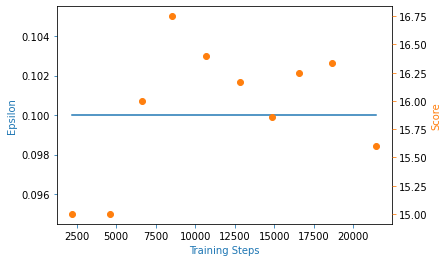

In [7]:
plot_learning_curve(steps_array, scores, eps_history, figure_file)